# Deep Autoencoder
An autoencoder, in general, is a network that is trained to attempt to copy its input to its output. Internally, it has a **latent space** that describes a code used to represent the input. The network may be viewed as consisting of two parts: an **encoder** function $h=f(x)$ and a **decoder** that produces a reconstruction $r=g(h)$.

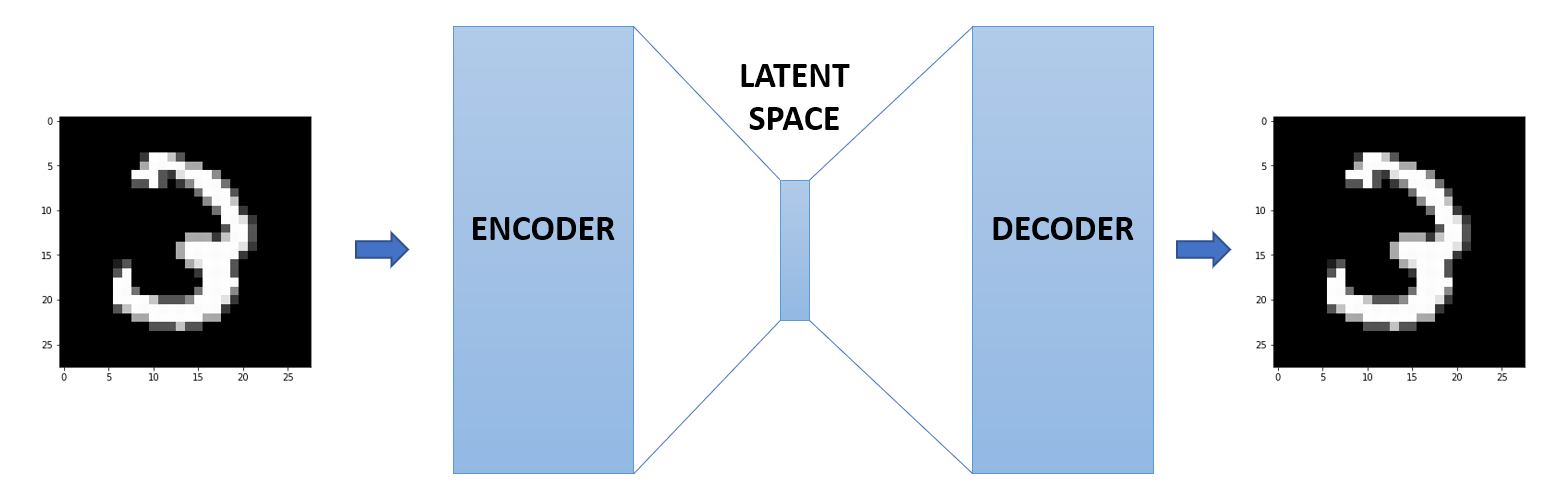

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import seaborn as sb 
sb.set_style( "darkgrid")

# Dataset

## Define the dataset

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Let's plot some random samples from the dataset. The first element of the sample is the actual image, while the second is the corresponding label.

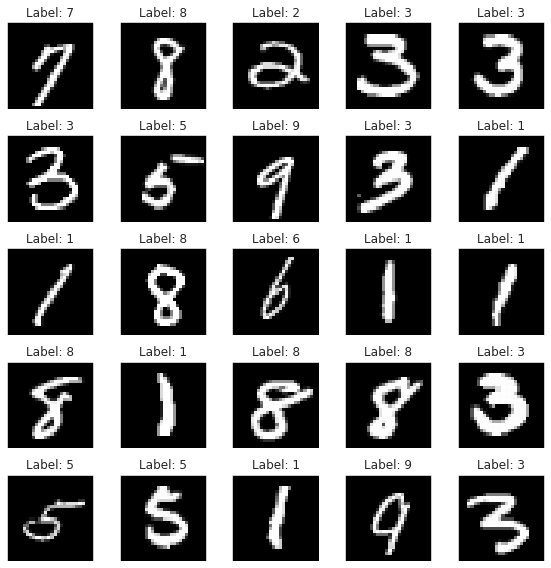

In [3]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

In this example we are using the input images without any modification. As always, the only requirement is to transform the input data to tensors of the proper shape.

In [6]:
# In this case the train_transform and test_transform are the same, but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


In [5]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## Define the dataloader

The dataloader allows to easily create batch of data, in this case we set a batch size of 256, and we also enable data shuffling for the training dataset.

In [6]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Model of the Autoencoder

### Encoder

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            
            # First convolutional layer
            nn.Conv2d(1, conv1, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            
            # Second convolutional layer
            nn.Conv2d(conv1, conv2, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            
            # Third convolutional layer
            nn.Conv2d(conv2, conv3, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)#dimension 0 is the sample, so we flatten from dimension 1

        ### Linear section
        self.encoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(3 * 3 * conv3, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            
            # Second linear layer
            nn.Linear(fc, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

### Decoder

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            
            # Second linear layer
            nn.Linear(fc, 3 * 3 * conv3),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3, conv2, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2, conv1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Initialize the two networks.

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

Let's check if all the shapes are correct.

In [10]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [11]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

### Set the random seed for reproducible results
torch.manual_seed(0)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout2d(p=0.5, inplace=False)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Network training test
#### Training function

In [12]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))

    return loss.data

#### Testing function

In [13]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

#### Training loop

In [14]:
### Training cycle
def training_cycle(num_epochs,early_stopping,encoder,decoder,loss_fn,optim,train_dataloader,device,test_dataset):
    train_loss_log = []
    val_loss_log = []
    
    #early stopping
    max_early=float("-inf")
    idx_early=-1
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training (use the training function)
        train_loss=train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
      
        train_loss_log.append(train_loss)
        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)
        
        val_loss_log.append(val_loss)
        # Print Validationloss
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.grid()
        plt.pause(0.1)
        # Save figures
        os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')
        torch.save(optim.state_dict(), 'optim_params.pth')
        
        #Early stopping:
        if idx_early==-1:
            idx_early=epoch
            max_early=val_loss
        elif round(float(val_loss),3)<round(float(max_early),3):
            idx_early=epoch
            max_early=val_loss
            
        elif epoch-idx_early>=early_stopping:
            print("STOPPED BY EARLY STOPPYNG")
            break

    return (train_loss_log,val_loss_log)


#### Hyperparameter optimization

In [15]:
#set the paraemets to exlore
space_dim = [2]
num_epochs=40
early_stopping=35
Conv1=[8,16, 32, 64]
Conv2=[16, 32, 64]
Conv3=[32, 64]
FC=[32, 64]
LR=[1e-5, 1e-4, 1e-3]
L2=[1e-5, 1e-4, 1e-3]
drop=[0.1, 0.5]

In [ ]:
hyperparams = [space_dim,Conv1,Conv2,Conv3,FC,LR,L2, drop]  

iterations=[]
import itertools
for hyper in itertools.product(*hyperparams):
    iterations.append(hyper)
print("Total Combinations:",len(iterations))


In [ ]:
import gc
best_hyper=None
best_loss=None
for i,hyper in enumerate(iterations):
    print("\n\nIteration:",i,hyper)
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2, drop=hyper
    
    ### Initialize the two networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
    decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

    # Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)
    
    
    #TRAINING CYCLE
    train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           device, 
                                           test_dataset)
    train_loss=train_loss_log[-1]
    val_loss=val_loss_log[-1]
    print("\tTrain Loss:",round(float(train_loss),3),"\tVal Loss:",round(float(val_loss),3))
    
    #saving the best model
    if not best_loss or val_loss<best_loss:
        best_loss=val_loss
        best_hyper=hyper


    gc.collect()

In [ ]:
print("\n\nBest Model:",best_hyper)



Best Model: (2, 8, 16, 64, 64, 0.001, 1e-05, 0.1)


## Best model

In [ ]:
### Retrain for best model
space_dim = [2]
num_epochs=40
early_stopping=35
Conv1=[8]
Conv2=[16]
Conv3=[ 64]
FC=[ 64]
LR=[ 1e-3]
L2=[1e-5]
drop=[0.1]

In [ ]:
hyper = [space_dim,Conv1,Conv2,Conv3,FC,LR,L2, drop]  

encoded_space_dim,conv1,conv2,conv3,fc,lr,l2, drop=hyper

### Initialize the two networks
encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

# Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


#TRAINING CYCLE
train_loss_log,val_loss_log=training_cycle(num_epochs,
                                       early_stopping,
                                       encoder,
                                       decoder,
                                       loss_fn,
                                       optim,
                                       train_dataloader,
                                       device, 
                                       test_dataset)
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("\tTrain Loss:",round(float(train_loss),3),"\tVal Loss:",round(float(val_loss),3))


### Network analysis

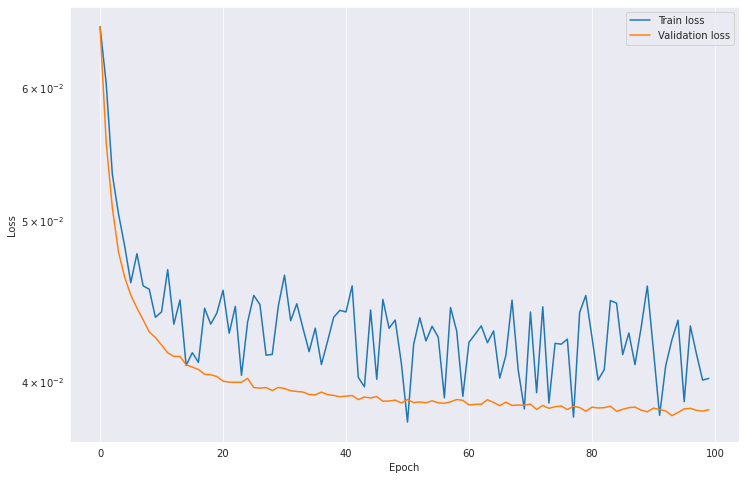

In [22]:
# Plot losses of the best model
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 


In [23]:
test_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)

In [24]:
#get the losses
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))
print("Test Loss:\t",round(float(test_loss),3))

Train Loss:	 0.04
Val Loss:	 0.039
Test Loss:	 0.039


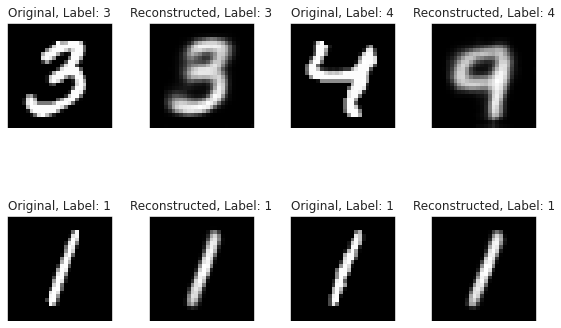

In [25]:
### Plot some sample
fig, axs = plt.subplots(2, 4, figsize=(8,6))
for ax in axs:
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  = encoder(img.unsqueeze(0).to(device))
        decoded_img  = decoder(encoded_img)
    
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[1].set_title('Reconstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  =encoder(img.unsqueeze(0).to(device))
        decoded_img  =decoder(encoded_img)
    
    ax[2].imshow(np.array(img1), cmap='gist_gray')
    ax[2].set_title('Original, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    ax[3].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[3].set_title('Reconstructed, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    
plt.tight_layout()

## Latents space

In [26]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

The encoder can be used to evaluate the latent space values for each of the test images. Since we used an encoded space dimension of 2, the encoder maps an entire image to just 2 floating point numbers.

We also save the corresponding label to show how each digit is mapped in the encoded space.

In [27]:
### Get the encoded representation of the test samples
encoded_samples = []
enc_aut = np.zeros(encoded_space_dim+1)
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    enc_aut = np.vstack( (enc_aut, np.hstack( (encoded_img, label)) ) )

100%|██████████| 10000/10000 [00:07<00:00, 1405.08it/s]


For convenience (not required), convert the result to a table format (`pandas.DataFrame`):

In [28]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,9.012648,1.060300,7
1,0.142933,-0.013474,2
2,10.109396,-41.378048,1
3,-4.604393,6.791766,0
4,2.872335,3.139371,4
...,...,...,...
9995,-0.053527,0.252063,2
9996,0.070349,-0.161850,3
9997,27.347897,37.133503,4
9998,-19.505226,-5.639075,5


This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [29]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

As you can see from the graph, even if we never used the labels (i.e. the actual digit written in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Princiapal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

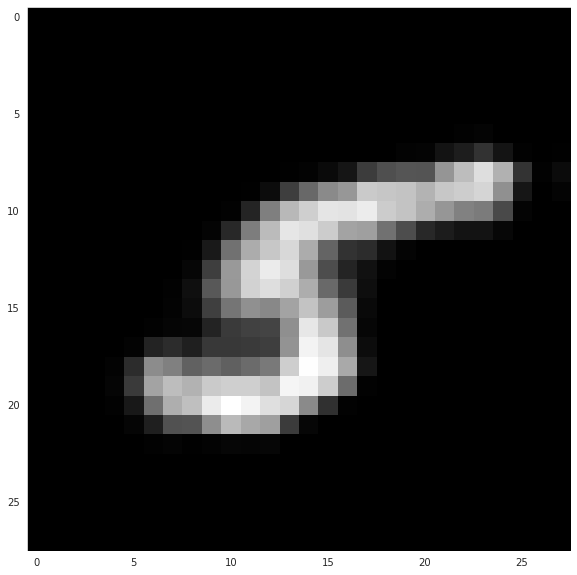

In [30]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-40, -20.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)
    
    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.grid()
    plt.show()

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.patches import Ellipse
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

# PCA
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(encoded_samples.iloc[:,0:encoded_space_dim])
columns = [ f'Enc. Variable {i}' for i in range(n_components)]
compressed_samples = pd.DataFrame( pca.transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns=columns )

if n_components == 2:
    fig = px.scatter(compressed_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)
elif n_components == 3:
    fig = px.scatter_3d(compressed_samples,  x='Enc. Variable 0', y='Enc. Variable 1', z='Enc. Variable 2',
                    color=encoded_samples.label.astype(str), opacity=0.7)
fig.show()

In [32]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

# TSNE
n_components = 2
tsne = TSNE(n_components=n_components)
tsne.fit(encoded_samples.iloc[:, 0:encoded_space_dim])
columns = [ f'Enc. Variable {i}' for i in range(n_components)]
compressed_samples = pd.DataFrame( tsne.fit_transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns=columns )

if n_components == 2:
    fig = px.scatter(compressed_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)
elif n_components == 3:
    fig = px.scatter_3d(compressed_samples,  x='Enc. Variable 0', y='Enc. Variable 1', z='Enc. Variable 2',
                    color=encoded_samples.label.astype(str), opacity=0.7)
fig.show()

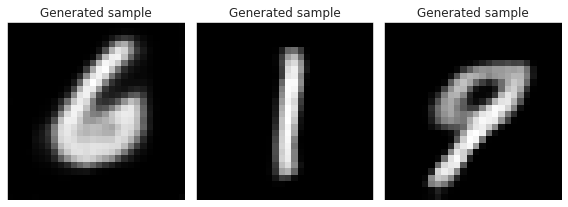

In [33]:
# Generation of new samples
### Plot some sample
fig, ax = plt.subplots(1, 3, figsize=(8,6))
img, label = random.choice(test_dataset)
img1 = img[0]
with torch.no_grad():
    encoded_img  = encoder(img.unsqueeze(0).to(device))
    decoded_img  = decoder(20*torch.randn_like(encoded_img).to(device) )

ax[0].imshow( decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[0].set_title('Generated sample' )
ax[0].set_xticks([])
ax[0].set_yticks([])

with torch.no_grad():
    decoded_img  = decoder(20*torch.randn_like(encoded_img).to(device) )

ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[1].set_title('Generated sample' )
ax[1].set_xticks([])
ax[1].set_yticks([])

img, label = random.choice(test_dataset)
img1 = img[0]
with torch.no_grad():
    decoded_img  = decoder(20*torch.randn_like(encoded_img).to(device) )

ax[2].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[2].set_title('Generated sample' )
ax[2].set_xticks([])
ax[2].set_yticks([])
    
    
plt.tight_layout()

# Fine tuning

In [ ]:
new_layer = nn.Linear(encoded_space_dim,10)

In [35]:
# Disallow the update of all the layers by setting the 'requires_grad' parameter of the tensors to 'False'
for param_name, param in encoder.named_parameters():
    param.requires_grad = False
    
# Allow the training of the last layers (classifier[4] and classifier[6])
for param in encoder.encoder_lin[2].parameters():
    param.requires_grad = True

for param in encoder.encoder_lin[0].parameters():
    param.requires_grad = True

# Check if correct
for param_name, param in encoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

#moving both the encoder and the layer for classification to GPU
new_layer.to(device)

# Define the loss function
loss_sup = nn.CrossEntropyLoss()

#optimize the parameters of both the encoder and the layer fot classification
params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': new_layer.parameters()}
    ]

optimizer_sup = torch.optim.Adam(params_to_optimize, lr=1e-3)
    

encoder_cnn.0.weight 	- requires_grad=False
encoder_cnn.0.bias 	- requires_grad=False
encoder_cnn.3.weight 	- requires_grad=False
encoder_cnn.3.bias 	- requires_grad=False
encoder_cnn.6.weight 	- requires_grad=False
encoder_cnn.6.bias 	- requires_grad=False
encoder_lin.0.weight 	- requires_grad=True
encoder_lin.0.bias 	- requires_grad=True
encoder_lin.3.weight 	- requires_grad=False
encoder_lin.3.bias 	- requires_grad=False
Training device: cuda


In [36]:
def finetune_train(encoderr, layer_new, train_dat):
    #allow training
    since = time.time()
    encoderr.train()
    layer_new.train()
    
    
    
    accuracy =[]
    loss =[]
    
    
    for sample_batched in train_dat:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        x = encoderr(x_batch)
        out = layer_new(x)

        # Compute loss
        loss = loss_sup(out, label_batch)

        # zero the parameter gradients
        encoderr.zero_grad()
        layer_new.zero_grad()
        
        #backpropagation
        loss.backward()

        # Update the weights
        optimizer_sup.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        loss.append(loss_batch)

        #get the accuracy for this batch
        pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
        
        
        #correct labels 
        right = np.sum(pred == np.array(label_batch.cpu()))
        accuracy.append(right)
        
        
    return accuracy, loss

In [37]:
def finetuning_val(encoderr, layer_new, val_data):
    accuracy = []
    loss = []
    encoderr.eval()
    layer_new.eval()
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_data:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            x = encoderr(x_batch)
            out = layer_new(x)

            # Compute loss
            loss = loss_sup(out, label_batch)

            loss_batch = loss.detach().cpu().numpy()
            loss.append(loss_batch)


            pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
            
            #correct prediction
            right = np.sum(pred == np.array(label_batch.cpu()))
            accuracy.append(right)
    return accuracy, loss

In [4]:
#supervised
alpha = 0.2
split = int(len(train_dataset) * 0.33)
train_set, val_set = torch.utils.data.random_split(train_dataset, [len(train_dataset)-split, split])

print('Samples in training set:',len(train_set))
print('Samples in validation set:',len(val_set))

Samples in training set: 40200
Samples in validation set: 19800


In [7]:
#apply transformation to train dataset and test dataset
train_set.transform = train_transform
val_set.transform = train_transform

#define train dataloader enabling the shuffle of the data
train_dataloader_sup = DataLoader(train_set, batch_size=256, shuffle=True)
#define test dataloader without shuffle the data
val_dataloader_sup = DataLoader(val_set, batch_size=len(val_set), shuffle=False)

In [9]:
train_dataloader_sup

In [65]:
### TRAINING LOOP
num_epochs = 60

acc_train = 0
acc_val = 0

train_loss_log = []
val_loss_log = []

for epoch_num in range(num_epochs):
    # Training mode 
    acc_train, train_loss = finetune_train(encoder, new_layer, train_dataloader_sup)

    # Save average train loss
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)

    # Evaluation mode (e.g. disable dropout)
    acc_val, val_loss = finetuning_val(encoder, new_layer, val_dataloader_sup)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    val_loss_log.append(val_loss)

    print("Epoch", epoch_num + 1, "= Average train loss:[", train_loss, "] ","Average validation loss: [", val_loss, "]")


Epoch 1 = Average train loss:[ 0.337165 ]  Average validation loss: [ 0.28510013 ]
Epoch 2 = Average train loss:[ 0.33329654 ]  Average validation loss: [ 0.2810851 ]
Epoch 3 = Average train loss:[ 0.33584452 ]  Average validation loss: [ 0.2807175 ]
Epoch 4 = Average train loss:[ 0.32275864 ]  Average validation loss: [ 0.27915514 ]
Epoch 5 = Average train loss:[ 0.3272856 ]  Average validation loss: [ 0.27939552 ]
Epoch 6 = Average train loss:[ 0.32187325 ]  Average validation loss: [ 0.27376375 ]
Epoch 7 = Average train loss:[ 0.32023016 ]  Average validation loss: [ 0.27378103 ]
Epoch 8 = Average train loss:[ 0.3084552 ]  Average validation loss: [ 0.27229434 ]
Epoch 9 = Average train loss:[ 0.3132667 ]  Average validation loss: [ 0.27055892 ]
Epoch 10 = Average train loss:[ 0.31029204 ]  Average validation loss: [ 0.27602404 ]
Epoch 11 = Average train loss:[ 0.30787164 ]  Average validation loss: [ 0.2705481 ]
Epoch 12 = Average train loss:[ 0.30467963 ]  Average validation loss: 

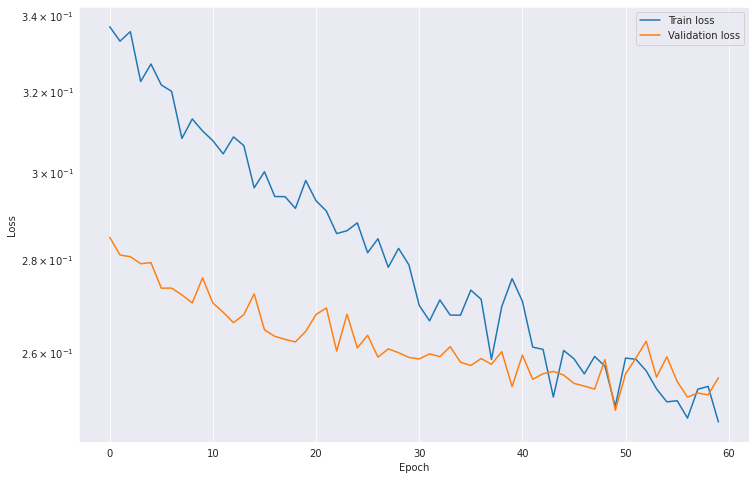

In [66]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [67]:
test_loss = []
test_acc = 0

y_test=[]
y_pred=[]

encoder.to(device)
#move the input to the GPU and predict the output
encoder.eval()
new_layer.eval()

with torch.no_grad(): # No need to track the gradients

    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        y = sample_batched[1].to(device)

        # Encode data
        x = encoder(x_batch)
        out = new_layer(x)

        y_test.append(y)
        y_pred.append(out)

        # Append the network output and the original image to the lists
        loss = loss_sup(out, y)
        test_loss.append(loss.detach().cpu().numpy())

        pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
        right = np.sum(pred == np.array(y.cpu()))
        test_acc = test_acc + right

    # Evaluate global loss
    test_loss = np.mean(test_loss)


print("Test loss MODEL:", float(test_loss))

print(" Accuracy of MODEL:", np.round(test_acc/len(test_dataset),5))


Test loss MODEL: 0.25256165862083435
 Accuracy of MODEL: 0.9521
